In [5]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal

from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt
# %matplotlib qt

import seaborn as sns
import bk.load
import bk.compute
import bk.plot

import os
%load_ext memory_profiler


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [6]:
def transition(states, template, epsilon=0):
    """
    author: BK
    states : dict of nts.Interval_set
    template : list of state.
    epsilon : int, will drop any 
     in which there is an epoch shorter than epsilon 's'
    This function will find transition that match the template 
    """
    if epsilon is list:
        print("eplist")
    long = pd.DataFrame()

    # Concatenate all epochs into a single dataframe
    for s, i in states.items():
        i["state"] = s
        long = pd.concat((i, long))
        del i["state"]
    order = np.argsort(long.start)
    long = long.iloc[order]


     
    transition_times = []
    transition_intervals = []
    # For each state, check if the next epochs match the template
    # If yes add the beginning of this epoch and then end of last one in transition_intervals. Save also the time of changes
    for i, s in enumerate(long.state):
        tmp = list(long.state[i: i + len(template)])
        if tmp == template:
            tmp_transition = long.iloc[i: i + len(template)]
            #             print(d.iloc[i:i+len(template)])
            length = (tmp_transition.end - tmp_transition.start) / 1_000_000
            if np.any(length.values < epsilon):
                continue
            tmp_pre = np.array(tmp_transition.end[:-1])
            tmp_post = np.array(tmp_transition.start[1:])
            tmp_times = np.mean([tmp_pre, tmp_post], 0)

            transition_intervals.append(
                [tmp_transition.start.iloc[0], tmp_transition.end.iloc[-1]]
            )
            transition_times.append(tmp_times)

    # Converting to intervals set in order to work with neuroseries easily
    transition_times = np.array(transition_times)
    transition_intervals = np.array(transition_intervals)
    transition_intervals = nts.IntervalSet(
        start=transition_intervals[:, 0],
        end=transition_intervals[:, 1],
        force_no_fix=True,
    )
    return transition_intervals, transition_times


# Small Demo

In [8]:
bk.load.current_session_linux()
states = bk.load.states()

# We are going to look for NREM-REM transitions
nrem_rem_intervals,nrem_rem_timings = transition(states,['sws','Rem'])

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713


# Plotting the computations

In [15]:
nrem_rem_timings

array([[1.92650e+09],
       [2.42950e+09],
       [3.27550e+09],
       [3.84150e+09],
       [3.91650e+09],
       [3.99250e+09],
       [4.52950e+09],
       [5.42650e+09],
       [6.06950e+09],
       [7.31150e+09],
       [7.75950e+09],
       [7.90950e+09],
       [8.79750e+09],
       [9.33350e+09],
       [1.61455e+10],
       [1.67655e+10],
       [1.72595e+10],
       [1.74295e+10],
       [1.78105e+10],
       [1.80765e+10],
       [1.85285e+10],
       [1.89795e+10],
       [1.91675e+10],
       [1.94485e+10],
       [1.97715e+10],
       [2.12865e+10],
       [2.16295e+10],
       [2.18505e+10]])

/tmp/ipykernel_619034/4287821694.py:1: MatplotlibDeprecationWarning: Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  fig,ax = plt.subplots(2,1,True)


Text(0.5, 1.0, 'NREM and REM epochs')

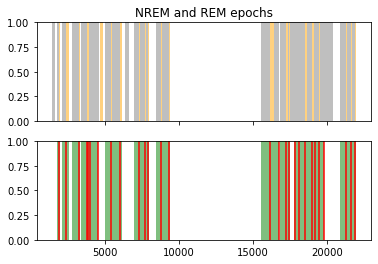

In [23]:
fig,ax = plt.subplots(2,1,True)
plt.sca(ax[0])
bk.plot.intervals(states['Rem'],'orange') # plot rem epochs in orange
bk.plot.intervals(states['sws'],'grey') # plot sws epochs in grey

plt.sca(ax[1])
bk.plot.intervals(nrem_rem_intervals,'green') # Plot nrem_rem epochs
for i in nrem_rem_timings/1_000_000: plt.axvline(i,color = 'red') # Plot timing of transitions

ax[0].set_title('NREM and REM epochs')